# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

analysis_name = 'SingleClassSVM'
data_path = os.getenv('OUTPUTDATAPATH')
results_path = os.getenv('PACKAGE_NAME')

base_results_path = '%s/%s'%(results_path,analysis_name)
pict_results_path = '%s/picts'%(base_results_path)
files_results_path = '%s/output_files'%(base_results_path)

# Read data
# Check if LofarData has created...
m_time = time.time()

database = '4classes'
n_pts_fft = 1024
decimation_rate = 3
spectrum_bins_left = 400
development_flag = True
development_events = 100

if not os.path.exists('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                      (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left)):
    print 'No Files in %s/%s\n'%(data_path,database)
else:
    #Read lofar data
    [data,trgt,class_labels] = joblib.load('%s/%s/lofar_data_file_fft_%i_decimation_%i_spectrum_left_%i.jbl'%
                                           (data_path,database,n_pts_fft,decimation_rate,spectrum_bins_left))


    m_time = time.time()-m_time
    print 'Time to read data file: '+str(m_time)+' seconds'

    # correct format
    all_data = data
    all_trgt = trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))
    
    # Process data
    # unbalanced data to balanced data with random data creation of small classes

    # Same number of events in each class
    qtd_events_biggest_class = 0
    biggest_class_label = ''

    for iclass, class_label in enumerate(class_labels):
        if sum(all_trgt==iclass) > qtd_events_biggest_class:
            qtd_events_biggest_class = sum(all_trgt==iclass)
            biggest_class_label = class_label
        print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
    print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


    balanced_data = {}
    balanced_trgt = {}

    from Functions import DataHandler as dh
    m_datahandler = dh.DataHandlerFunctions()

    for iclass, class_label in enumerate(class_labels):
        if development_flag:
            class_events = all_data[all_trgt==iclass,:]
            if len(balanced_data) == 0:
                balanced_data = class_events[0:development_events,:]
                balanced_trgt = (iclass)*np.ones(development_events)
            else:
                balanced_data = np.append(balanced_data,
                                          class_events[0:development_events,:], 
                                          axis=0)
                balanced_trgt = np.append(balanced_trgt,(iclass)*np.ones(development_events))
        else:
            if len(balanced_data) == 0:
                class_events = all_data[all_trgt==iclass,:]
                balanced_data = m_datahandler.CreateEventsForClass(
                    class_events,qtd_events_biggest_class-(len(class_events)))
                balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
            else:
                class_events = all_data[all_trgt==iclass,:]
                created_events = (m_datahandler.CreateEventsForClass(all_data[all_trgt==iclass,:],
                                                                     qtd_events_biggest_class-
                                                                     (len(class_events))))
                balanced_data = np.append(balanced_data,created_events,axis=0)
                balanced_trgt = np.append(balanced_trgt,
                                          (iclass)*np.ones(created_events.shape[0]),axis=0)
        
    all_data = balanced_data
    all_trgt = balanced_trgt

    # turn targets in sparse mode
    from keras.utils import np_utils
    trgt_sparse = np_utils.to_categorical(all_trgt.astype(int))

Time to import all libraries: 0.000263929367065 seconds
Time to read data file: 6.35859584808 seconds


Using TensorFlow backend.


Qtd event of 0 is 12939
Qtd event of 1 is 29352
Qtd event of 2 is 11510
Qtd event of 3 is 23760

Biggest class is 1 with 29352 events


In [3]:
from sklearn import preprocessing
from sklearn import svm

def SVMNoveltyTrainFunction(data=None, trgt=None, inovelty=0, 
                            ifold=0, n_folds=2, nu_value=0.5, 
                            trn_params=None, save_path='',
                            verbose=False, dev=False):
    
    # load or create cross validation ids
    CVO = trnparams.NoveltyDetectionFolds(folder=save_path,n_folds=n_folds,trgt=trgt,dev=dev)
    
    model_prefix_str = 'RawData_%i_novelty'%(inovelty)
    analysis_path = 'SingleClassSVM'
    nu_value_str = ('%1.5f'%nu_value).replace('.','_')
    
    params_str = trn_params.get_params_str()
    
    model_str = '%s/%s/%s_%i_folds_%s_%s_nu_value'%(save_path,analysis_path,
                                                    model_prefix_str,
                                                    n_folds,
                                                    params_str,
                                                    nu_value_str)
    if not development_flag:
        file_name = '%s_%i_fold_model.jbl'%(model_str,ifold)
    else:
        file_name = '%s_%i_fold_model_dev.jbl'%(model_str,ifold)
        
    if verbose:
        print file_name
    
    if not os.path.exists(file_name):
        # training
        
        classifiers = {}
        novelty_detector = []
        
        train_id, test_id = CVO[inovelty][ifold]

        # normalize data based in train set
        if trn_params.params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(data[train_id,:])
        elif trn_params.params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(data[train_id,:])
        elif trn_params.params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(data[train_id,:])

        norm_data = scaler.transform(data)
        
        # class specialist
        for iclass, m_class in enumerate(np.unique(trgt)):
            classifiers[iclass] = svm.OneClassSVM(nu=nu_value, 
                                                  kernel=trn_params.params['kernel'], 
                                                  gamma=trn_params.params['gamma'])
            classifiers[iclass].fit(norm_data[trgt==m_class])
        novelty_detector = svm.OneClassSVM(nu=nu_value, 
                                           kernel=trn_params.params['kernel'], 
                                           gamma=trn_params.params['gamma'])
        novelty_detector.fit(norm_data)
        if verbose:
            print 'saving file'
        joblib.dump([classifiers, novelty_detector],file_name,compress=9) 
    else:
        # loading
        if verbose:
            print 'file does exist'
        [classifiers, novelty_detector] = joblib.load(file_name)
    return classifiers, novelty_detector

In [146]:
# Train example

from Functions import TrainParameters as trnparams


analysis_str = 'SingleClassSVM'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.SVMNoveltyDetectionTrnParams(gamma=0.1)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.SVMNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)


n_folds = 2
CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    for inu in np.arange(0.5,0.6,0.1):
        for ifold in range(len(CVO[inovelty])):
            print 'Novelty class: %01.0f - nu value: %01.3f - fold %i'%(novelty_class,inu, ifold)
            
            trn_data = all_data[all_trgt!=novelty_class]
            trn_trgt = all_trgt[all_trgt!=novelty_class]
            
            SVMNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                    ifold=ifold, n_folds=len(CVO[inovelty]), nu_value=inu, 
                                    trn_params=trn_params, save_path=results_path, verbose=False,
                                    dev=True)
            
            

Novelty class: 0 - nu value: 0.500 - fold 0
Novelty class: 0 - nu value: 0.500 - fold 1
Novelty class: 1 - nu value: 0.500 - fold 0
Novelty class: 1 - nu value: 0.500 - fold 1
Novelty class: 2 - nu value: 0.500 - fold 0
Novelty class: 2 - nu value: 0.500 - fold 1
Novelty class: 3 - nu value: 0.500 - fold 0
Novelty class: 3 - nu value: 0.500 - fold 1


file exists


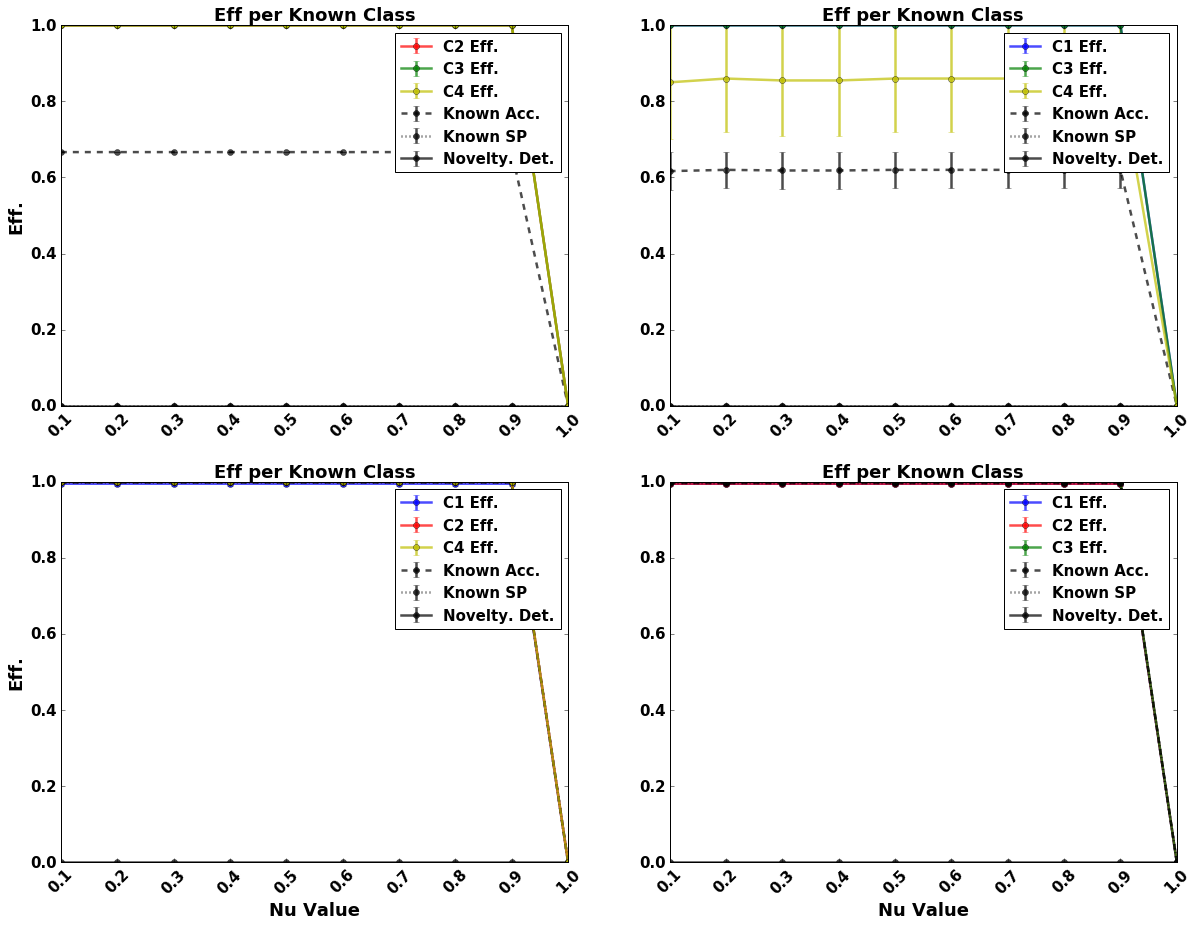

In [6]:
# analysis example - nu value variation

from sklearn import preprocessing
from Functions import TrainParameters as trnparams


# generate analysis data
save_path=results_path

analysis_str = 'SingleClassSVM'
model_prefix_str = 'RawData'

trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(trn_params_folder):
    trn_params = trnparams.SVMNoveltyDetectionTrnParams(gamma=0.1)
    trn_params.save(trn_params_folder)
else:
    trn_params = trnparams.SVMNoveltyDetectionTrnParams()
    trn_params.load(trn_params_folder)

analysis_file_name='%s/%s/%s_nu_value_sweep.jbl'%(results_path,analysis_str,analysis_name)

if not os.path.exists(analysis_file_name):
    trn_params_folder='%s/%s/%s_trnparams.jbl'%(results_path,analysis_str,analysis_name)
    
    if not os.path.exists(trn_params_folder):
        trn_params = trnparams.SVMNoveltyDetectionTrnParams(gamma=0.011)
        trn_params.save(trn_params_folder)
    else:
        trn_params = trnparams.SVMNoveltyDetectionTrnParams()
        trn_params.load(trn_params_folder)

    params_str = trn_params.get_params_str()
    n_folds = 2
    CVO = trnparams.NoveltyDetectionFolds(folder=results_path,n_folds=n_folds,trgt=all_trgt,dev=development_flag)

    nu_mat = np.arange(0.1,1.1,0.1)

    class_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(np.unique(all_trgt)),len(nu_mat)])
    novelty_eff_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(nu_mat)])
    known_acc_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(nu_mat)])
    known_sp_mat = np.zeros([n_folds,len(np.unique(all_trgt)),len(nu_mat)])
    
    for inovelty, novelty_class in enumerate(np.unique(trgt)):
        trn_data = all_data[all_trgt!=novelty_class]
        trn_trgt = all_trgt[all_trgt!=novelty_class]
        for ifold in range(len(CVO[inovelty])):
            for inu,nu_value in enumerate(nu_mat): 
                #print 'Novelty class: %01.0f - nu value: %01.3f - fold %i'%(novelty_class,nu_value, ifold)
                [classifiers,novelty_detector] = SVMNoveltyTrainFunction(data=trn_data, trgt=trn_trgt, inovelty=inovelty, 
                                                ifold=ifold, n_folds=len(CVO[inovelty]), nu_value=nu_value, 
                                                trn_params=trn_params, save_path=results_path, dev=True)
                buff = np.zeros([len(np.unique(trgt))-1])
                for iclass, m_class in enumerate(np.unique(trn_trgt)):
                    if m_class == novelty_class:
                        output = novelty_detector.predict(all_data[all_trgt==novelty_class])
                        novelty_eff_mat[ifold,int(novelty_class),inu]= float(sum(output==-1.))/float(len(output))
                    else:
                        output = classifiers[iclass].predict(trn_data[trn_trgt==m_class])
                        class_eff_mat[ifold,int(novelty_class),int(m_class),inu] = float(sum(output==1.))/float(len(output))
                        buff[iclass-(iclass>inovelty)] = float(sum(output==1.))/float(len(output))
                known_acc_mat[ifold,int(novelty_class),inu]= np.mean(buff,axis=0)
                known_sp_mat[ifold,int(novelty_class),inu]= (
                    np.sqrt(np.mean(buff,axis=0)*np.power(np.prod(buff),1./float(len(buff)))))
    joblib.dump([class_eff_mat,novelty_eff_mat, known_acc_mat, known_sp_mat,nu_mat],analysis_file_name,compress=9)
else:
    print 'file exists'
    [class_eff_mat, novelty_eff_mat, known_acc_mat, known_sp_mat,nu_mat] = joblib.load(analysis_file_name) 

# plot analysis
import matplotlib.pyplot as plt
%matplotlib inline  

fig = plt.subplots(figsize=(20,15))

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rc('legend',**{'fontsize':15})
plt.rc('font', weight='bold')

m_colors = ['b', 'r', 'g', 'y']

for inovelty, novelty_class in enumerate(np.unique(all_trgt)):
    ax = plt.subplot(2,2,inovelty+1)
    for iclass, m_class in enumerate(np.unique(all_trgt)):
        if novelty_class == m_class:
            #a = 0
            ax.errorbar(nu_mat,np.mean(novelty_eff_mat[:,int(novelty_class),:],axis=0),
                        np.std(novelty_eff_mat[:,int(novelty_class),:],axis=0),fmt='o-',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Novelty. Det.')
            ax.errorbar(nu_mat,np.mean(known_acc_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_acc_mat[:,int(novelty_class),:],axis=0),fmt='o--',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known Acc.')
            ax.errorbar(nu_mat,np.mean(known_sp_mat[:,int(novelty_class),:],axis=0),
                        np.std(known_sp_mat[:,int(novelty_class),:],axis=0),fmt='o:',
                        color='k',alpha=0.7,linewidth=2.5,
                        label='Known SP')
        else:
            ax.errorbar(nu_mat,np.mean(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),
                        np.std(class_eff_mat[:,int(novelty_class),int(m_class),:],axis=0),fmt='o-',
                        color=m_colors[int(m_class)],alpha=0.7,linewidth=2.5,
                       label='C%i Eff.'%(int(m_class)+1))
    ax.set_xticks(nu_mat)
    ax.set_xticklabels(nu_mat,rotation=45)
    ax.set_title('Eff per Known Class',fontsize=18,weight='bold')
    if inovelty > 1:
        ax.set_xlabel('Nu Value',fontsize=18,weight='bold')
    if inovelty == 0 or inovelty == 2:
        ax.set_ylabel('Eff.',fontsize=18,weight='bold')
        
    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, ncol=1)
    